In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torchvision.transforms.functional import rotate


# 하이퍼파라미터
num_classes = 4
num_epoch = 128
batch_size = 64
learning_rate = 0.001

# MPS 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 데이터 전처리
transform_base = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# 데이터셋 로드
data_dir = './emotion_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), transform=transform_base)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), transform=transform_base)
test_dataset = ImageFolder(os.path.join(data_dir, 'test'), transform=transform_base)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# "middle 모델" 정의
class ModifiedResNet18_MiddleBlock(nn.Module):
    def __init__(self, original_model):
        super(ModifiedResNet18_MiddleBlock, self).__init__()
        self.features_before_middle = nn.Sequential(*list(original_model.children())[:6])  # 중간 이전
        self.middle_block = nn.Sequential(  # 새로운 중간 블록
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
        )
        self.features_after_middle = nn.Sequential(*list(original_model.children())[6:-2])  # 중간 이후
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features_before_middle(x)
        identity = x
        x = self.middle_block(x)
        x += identity  # Skip connection
        x = nn.ReLU(inplace=True)(x)
        x = self.features_after_middle(x)
        x = nn.AdaptiveAvgPool2d(1)(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# ResNet18 기반 모델 생성
original_model = models.resnet18(pretrained=True)
original_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Grayscale
middle_model = ModifiedResNet18_MiddleBlock(original_model)
middle_model.to(device)




Using device: cuda


c:\Users\DS\anaconda3\envs\EIC_LAB\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DS\anaconda3\envs\EIC_LAB\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ModifiedResNet18_MiddleBlock(
  (features_before_middle): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, af

In [24]:
# Focal Loss 정의
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        """
        Focal Loss for classification tasks.

        Args:
            alpha (float): Weighting factor for the rare class.
            gamma (float): Focusing parameter to adjust the rate at which easy examples are down-weighted.
            reduction (str): Reduction method ('mean', 'sum', or 'none').
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)  # CrossEntropyLoss 계산
        pt = torch.exp(-ce_loss)  # 확률 계산
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [25]:
def plot_training_progress(train_accuracies, val_accuracies, train_losses):
    # 학습 정확도 및 검증 정확도 그래프
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy per Epoch")
    plt.legend()

    # 손실 함수 그래프
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss per Epoch")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
from torch.optim.lr_scheduler import StepLR

def train_model(model, train_loader, val_loader, num_epoch, learning_rate):
    criterion = FocalLoss(alpha=1, gamma=2)
    #criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #학습률 조정 함수 추가
    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)  # 30 에포크마다 학습률을 0.1배로 감소

    best_accuracy = 0.0
    best_model_state = None

    train_accuracies = []  # 에포크별 학습 정확도 저장
    val_accuracies = []    # 에포크별 검증 정확도 저장
    train_losses = []      # 에포크별 학습 손실 저장

    for epoch in range(num_epoch):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            # 데이터 증강: 20% 확률로 회전
            if np.random.rand() < 0.2:
                angles = np.random.uniform(-5, 5, size=inputs.size(0))
                inputs = torch.stack([rotate(img, angle) for img, angle in zip(inputs, angles)])

            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = (correct / total) * 100
        train_accuracies.append(train_accuracy)  # 학습 정확도 저장
        train_losses.append(running_loss / len(train_loader))  # 학습 손실 저장

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = (correct / total) * 100
        val_accuracies.append(val_accuracy)  # 검증 정확도 저장

        #학습률 조정 함수 호출
        scheduler.step()


        print(f"Epoch [{epoch + 1}/{num_epoch}] - Loss: {running_loss / len(train_loader):.4f}, "
        f"Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_state = model.state_dict()

    if best_model_state:
        torch.save(best_model_state, "final_emoticlass.pth")
        print(f"Best model saved with Val Acc: {best_accuracy:.2f}%")

    # 학습 종료 후 그래프 출력
    plot_training_progress(train_accuracies, val_accuracies, train_losses)


# 테스트 함수
def test_model(model, test_loader):
    model.load_state_dict(torch.load("final_emoticlass.pth"))
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    test_accuracy = correct / total
    print(f"Test Accuracy: {test_accuracy:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(num_classes)))
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

Epoch [1/128] - Loss: 0.3378, Train Acc: 70.10%, Val Acc: 73.16%
Epoch [2/128] - Loss: 0.2429, Train Acc: 76.87%, Val Acc: 72.81%
Epoch [3/128] - Loss: 0.2178, Train Acc: 79.11%, Val Acc: 76.10%
Epoch [4/128] - Loss: 0.1952, Train Acc: 80.90%, Val Acc: 76.75%
Epoch [5/128] - Loss: 0.1832, Train Acc: 81.57%, Val Acc: 74.68%
Epoch [6/128] - Loss: 0.1633, Train Acc: 82.75%, Val Acc: 76.98%
Epoch [7/128] - Loss: 0.1448, Train Acc: 84.31%, Val Acc: 78.73%
Epoch [8/128] - Loss: 0.1286, Train Acc: 85.63%, Val Acc: 75.45%
Epoch [9/128] - Loss: 0.1188, Train Acc: 86.73%, Val Acc: 78.39%
Epoch [10/128] - Loss: 0.0979, Train Acc: 88.64%, Val Acc: 75.60%
Epoch [11/128] - Loss: 0.0895, Train Acc: 89.40%, Val Acc: 78.39%
Epoch [12/128] - Loss: 0.0711, Train Acc: 91.23%, Val Acc: 76.86%
Epoch [13/128] - Loss: 0.0644, Train Acc: 92.34%, Val Acc: 77.36%
Epoch [14/128] - Loss: 0.0557, Train Acc: 93.28%, Val Acc: 77.74%
Epoch [15/128] - Loss: 0.0512, Train Acc: 93.90%, Val Acc: 78.81%
Epoch [16/128] - Lo

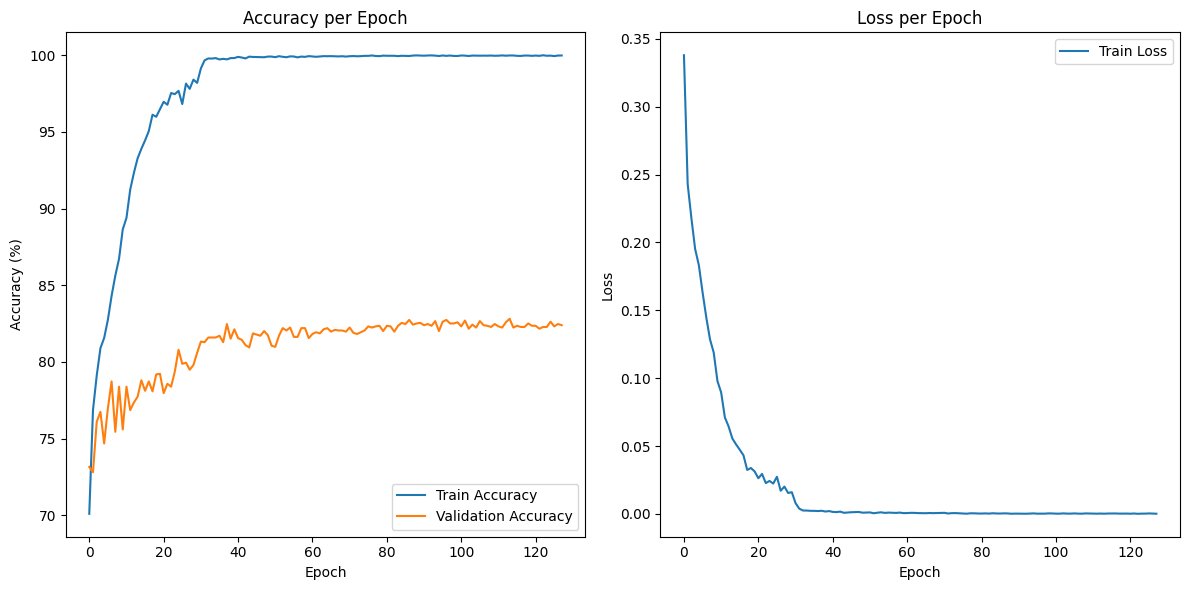

Test Accuracy: 0.8435


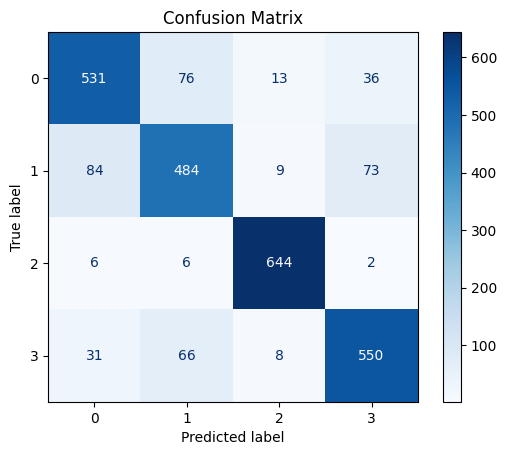

In [27]:
# 학습 및 테스트
train_model(middle_model, train_loader, val_loader, num_epoch, learning_rate)
test_model(middle_model, test_loader)